In [ ]:
import json
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import hdbscan
import nltk
from collections import Counter
from scipy.stats import entropy
import string
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding
import networkx as nx
import umap.umap_ as umap

In [2]:
with open("processed_decomposed_dataset.jsonl", "r") as f:
    data_txt = [json.loads(x) for x in f.readlines()]

In [3]:
data_txt[4]

{'query': 'I have a project where we deploy the "Vertex AI Vision SDK" into a container in Docker Desktop on the client computer on the edge and the sdk pushes the camera feed from the rtsp to Google Cloud\'s Vertex AI Vision and it goes through pre-trained human/vehicle model to find out count and that information is written into BigQuery in json format. This information will be queried and provided back to the customer in json response. \n\nI would like to identify the roundtrip time from the start of the stream to the json response. However the timestamp on the camera is off. It\'s hard to evaluate the roundtrip time. \n\nProvide me methodologies/ideas on how to accurately calculate the roundtrip time.',
 'output_a': 'To accurately calculate the roundtrip time for your Vertex AI Vision SDK container deployment, you can use the following methodologies:\n\n1. Add a timestamp to the camera feed: You can add a timestamp to the camera feed that is sent to Vertex AI Vision. This will allo

In [4]:
data_df = pd.DataFrame(data_txt)

In [5]:
data_df

query  \
0     Define Signal Discuss its various properties w...   
1     Please make a list of independent Fertility co...   
2     Explain various data mining functionalities wi...   
3     How do I change the short cut on mac osx to to...   
4     I have a project where we deploy the "Vertex A...   
...                                                 ...   
9114  I want to open the developler tools in chrome ...   
9115  Market trends in the 13th century in france\n<...   
9116  how the HS code reffers to commodity code and ...   
9117  Historically, when interest rates flatten from...   
9118  Here are column names of a spreadsheet called ...   

                                               output_a  \
0     A signal is a form of energy that is used to t...   
1     Sure, here are some independent Fertility coac...   
2     Data mining is a process of discovering patter...   
3     To change the shortcut on Mac OS X to toggle t...   
4     To accurately calculate the roundtrip time for...   
...                                                 ...   
9114  I'm here to help! It's possible that the websi...   
9115  The economic and agricultural growth in 13th c...   
9116  The HS code, commodity code, and commodity fam...   
9117  For each of the housing market declines listed...   
9118  The column names titled 'Everyday Financials' ...   

                                               M_a_text  \
0     Begins by interpreting the user's request, pro...   
1     Signals intent to fulfill the user's request a...   
2     Begins by interpreting the user's request, def...   
3     Sets up a clear instructional intent, restatin...   
4     Restates the user's goal and frames the respon...   
...                                                 ...   
9114  Expresses intent to help and frames the proble...   
9115  Begins by framing the historical context and c...   
9116  Begins by framing the answer as a summary and ...   
9117  Restates the user's comparative causal questio...   
9118  The response frames the spreadsheet as relatin...   

                                               T_a_text  \
0     Transitions into a structured breakdown of sig...   
1     Implements the plan by presenting a numbered l...   
2     Transitions into a structured list, systematic...   
3     Implements a detailed, sequential procedure wi...   
4     Organizes the answer as a numbered list of dis...   
...                                                 ...   
9114  Suggests a step-by-step approach to confirm th...   
9115  Considers possible indirect effects, explores ...   
9116  Implements the plan by sequentially defining e...   
9117  Implements a structured, itemized approach by ...   
9118  Lists and briefly describes the types of finan...   

                                               A_a_text M_a_span   T_a_span  \
0     A signal is a form of energy that is used to t...  [0, 27]  [28, 102]   
1     1. Fertility Authority\n2. Fertility Solutions...  [0, 18]   [19, 70]   
2     These are just a few examples of the many diff...  [0, 27]  [28, 169]   
3     That's it! Now you can use the key combination...  [0, 18]  [19, 143]   
4     By using one or more of these methodologies, y...  [0, 19]  [20, 120]   
...                                                 ...      ...        ...   
9114  If you need to use the developer tools on this...  [0, 33]  [34, 107]   
9115  Overall, the 13th century was a time of signif...  [0, 34]  [35, 130]   
9116  In summary, HS codes, commodity codes, and com...  [0, 19]  [20, 117]   
9117  In all three cases, a change in the Federal Re...  [0, 27]  [28, 172]   
9118  Based on the column names, it appears that thi...  [0, 20]   [20, 74]   

        A_a_span                                             S_a  \
0       [0, 121]                 Define and List Core Properties   
1       [19, 70]            List Format with Placeholder Filling   
2     [170, 239]                     Define, List, and Exempl

In [6]:
data_df['label'].value_counts()

label
 0    2007
 1    1686
-1    1345
 2    1328
-2    1233
 3     769
-3     751
Name: count, dtype: int64

In [7]:
def MTA_span_analysis(row):
    out_a = row['output_a']
    len_a = len(out_a.split(" "))
    out_b = row['output_b']
    len_b = len(out_b.split(" "))

    M_a_start, M_a_end = row['M_a_span'] if len(row['M_a_span']) == 2 else (0, 0)
    T_a_start, T_a_end = row['T_a_span'] if len(row['T_a_span']) == 2 else (0, 0)
    A_a_start, A_a_end = row['A_a_span'] if len(row['A_a_span']) == 2 else (0, 0)

    M_b_start, M_b_end = row['M_b_span'] if len(row['M_b_span']) == 2 else (0, 0)
    T_b_start, T_b_end = row['T_b_span'] if len(row['T_b_span']) == 2 else (0, 0)
    A_b_start, A_b_end = row['A_b_span'] if len(row['A_b_span']) == 2 else (0, 0)

    row['len_a'] = len_a
    row['len_b'] = len_b

    row['start_M_a'] = M_a_start / len_a
    row['end_M_a'] = M_a_end / len_a

    row['start_T_a'] = T_a_start / len_a
    row['end_T_a'] = T_a_end / len_a

    row['start_A_a'] = A_a_start / len_a
    row['end_A_a'] = A_a_end / len_a

    row['start_M_b'] = M_b_start / len_b
    row['end_M_b'] = M_b_end / len_b

    row['start_T_b'] = T_b_start / len_b
    row['end_T_b'] = T_b_end / len_b

    row['start_A_b'] = A_b_start / len_b
    row['end_A_b'] = A_b_end / len_b
    return row


In [8]:
new_df = data_df.apply(MTA_span_analysis, axis=1)

In [9]:
new_df["len_a"].mean(), new_df["len_b"].mean()

(228.88112731659174, 249.31922359907884)

In [10]:
new_df['start_A_a'].mean(), new_df['end_A_a'].mean(), new_df['start_A_b'].mean(), new_df['end_A_b'].mean()

(0.4307368504152278,
 1.3082202833196537,
 0.45925024884786353,
 1.1208677887501024)

In [11]:
new_df['start_M_a'].mean(), new_df['end_M_a'].mean(), new_df['start_M_b'].mean(), new_df['end_M_b'].mean()

(0.0008669570099153305,
 0.1302537237003171,
 0.0009955354937316802,
 0.1422490106064255)

In [12]:
new_df['start_T_a'].mean(), new_df['end_T_a'].mean(), new_df['start_T_b'].mean(), new_df['end_T_b'].mean()

(0.12077780836506036,
 0.6252283212456938,
 0.12851892285585936,
 0.6397229096659025)

In [13]:
S = pd.Series(list(new_df['S_a']) + list(new_df['S_b']))
M = pd.Series(list(new_df['M_a_text']) + list(new_df['M_b_text']))
T = pd.Series(list(new_df['T_a_text']) + list(new_df['T_b_text']))

In [14]:
S.value_counts()

Enumerate and Explain                       76
Enumerate and Summarize                     68
Stepwise Instructional Guide                61
Enumerate and Advise                        57
Request Clarification                       54
                                            ..
Stepwise Calculation with Labels             1
Direct JSON Listing                          1
Table with Data Validation                   1
Tabular Comparative Analysis                 1
Detailed Breakdown and Purpose Statement     1
Name: count, Length: 15597, dtype: int64

In [15]:
M.value_counts()

Not explicitly present                                                                                                                                                               455
Expresses uncertainty about the user's intent and requests clarification before proceeding.                                                                                            4
Restates the context and signals a summary of the result, showing the model is referencing prior calculation and preparing to deliver the answer.                                      2
Begins by directly defining the term, showing intent to provide a clear, concise explanation tailored to the user's question.                                                          2
Begins by explicitly restating the user's request, signaling understanding and intent to fulfill it.                                                                                   2
                                                                           

In [16]:
T.value_counts()

Not explicitly present                                                                                                                                                                                                                        281
Offers assistance by explicitly asking if the user needs help, inviting further interaction.                                                                                                                                                    3
Asks a clarifying question to gather more information before proceeding.                                                                                                                                                                        2
Transitions from the framing to the execution by presenting the list of patient IDs that fit the specified age range, using a direct enumeration format.                                                                                        2
Implements the plan by formattin

In [17]:
M = M[M!="Not explicitly present"]
T = T[T!="Not explicitly present"]

In [18]:
M.isna().sum(), T.isna().sum()

(0, 0)

In [19]:
prompts = {
    "M": M,
    "T": T,
    "S": S
}

In [ ]:
model = SentenceTransformer('all-mpnet-base-v2')  # strong general-purpose model

embeddings = {k: model.encode(list(v), normalize_embeddings=True) for k, v in prompts.items()}

c:\Users\kachr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


c:\Users\kachr\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# clustererM = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_method='eom', prediction_data=True)
# clustererT = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_method='eom', prediction_data=True)
# clustererS = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_method='eom', prediction_data=True)
# labels_m = clustererM.fit_predict(embeddings_M)
# labels_t = clustererT.fit_predict(embeddings_T)
# labels_s = clustererS.fit_predict(embeddings_S)

clusterer = {
    "M": hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_method='eom', prediction_data=True),
    "T": hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_method='eom', prediction_data=True),
    "S": hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_method='eom', prediction_data=True)
}

labels = { k: clusterer[k].fit_predict(embeddings[k]) for k in embeddings.keys() }


c:\Users\kachr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kachr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kachr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kachr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kachr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\d

In [23]:
# Compute entropy at each position
def token_entropy(tokens_at_pos):
    counts = Counter(tokens_at_pos)
    probs = np.array([count / len(tokens_at_pos) for count in counts.values()])
    return entropy(probs, base=2)

In [24]:
IGNORE_TOKENS = {"and", "the", "<pad>"} | set(string.punctuation)

In [25]:
def entropy_based_template_generator(cluster, thresh=0.5):
    # Tokenize and lowercase
    tokenized = [nltk.word_tokenize(sent.lower()) for sent in cluster]

    # Pad sentences to same length
    max_len = max(len(tokens) for tokens in tokenized)
    padded = [tokens + ['<pad>'] * (max_len - len(tokens)) for tokens in tokenized]

    # Transpose to group tokens by position
    by_position = list(zip(*padded))

    # Calculate entropy at each token position
    entropies = [token_entropy(pos) for pos in by_position]
    threshold = max(entropies) * thresh

    # Generate template
    template = []
    for pos_tokens, ent in zip(by_position, entropies):
        if ent < threshold:
            most_common = Counter(pos_tokens).most_common(1)[0][0]
            if most_common not in IGNORE_TOKENS:
                template.append(most_common)
        else:
            template.append("...")

    # Post-process to clean up spacing
    final_template = ' '.join(template).replace(" ,", ",").replace(" .", ".").replace(" !", "!").replace(" ?", "?")
    return final_template, entropies


--- Cluster M -1 ---
Sample-1: Begins by interpreting the user's request, providing a general definition of 'signal' and establishing the context for further explanation.
Sample-2: Signals intent to fulfill the user's request and frames the response as a list, indicating understanding of the instruction.
Sample-3: Begins by interpreting the user's request, defining data mining, and setting a context for the explanation.
Template: begins................................................

--- Cluster M 189 ---
Sample-1: Sets up a clear instructional intent, restating the user's goal and signaling a step-by-step approach.
Sample-2: Sets up a step-by-step instructional approach, indicating the response will guide the user through the process.
Sample-3: Sets up a clear instructional intent by directly addressing the user's goal and framing the response as a step-by-step guide.
Template: sets up a clear instructional intent by a...........................

--- Cluster M 50 ---
Sample-1: The m

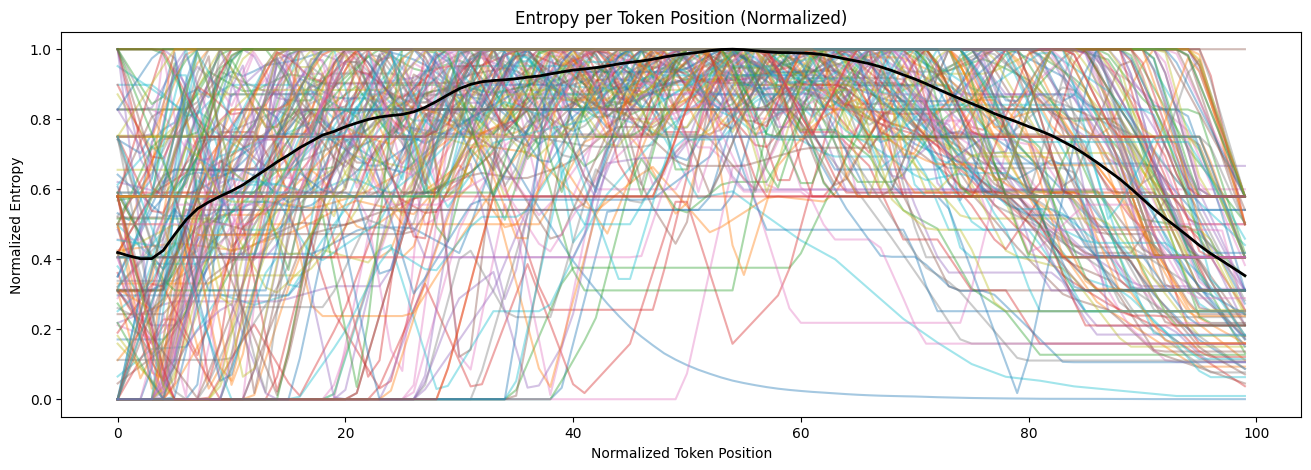


--- Cluster T 2 ---
Sample-1: Transitions into a structured breakdown of signal properties, listing and defining amplitude, frequency, and phase, and then explains how a diagram (waveform) can represent these properties.
Sample-2: Implements the plan by presenting a numbered list format, but after a few unique entries, repeats a generic placeholder name to fill out the list.
Sample-3: Transitions into a structured list, systematically naming and describing each functionality, and providing an example for each.
Template: implements... by............................................................

--- Cluster T -1 ---
Sample-1: Provides a brief factual justification by mentioning the origin and widespread adoption of PDF.
Sample-2: Breaks down the abstract into sequential, simplified explanations: describes the specific metamaterial, explains how it works, details the experiment and its results, and discusses potential applications.
Sample-3: Explains the need to check for both keys in

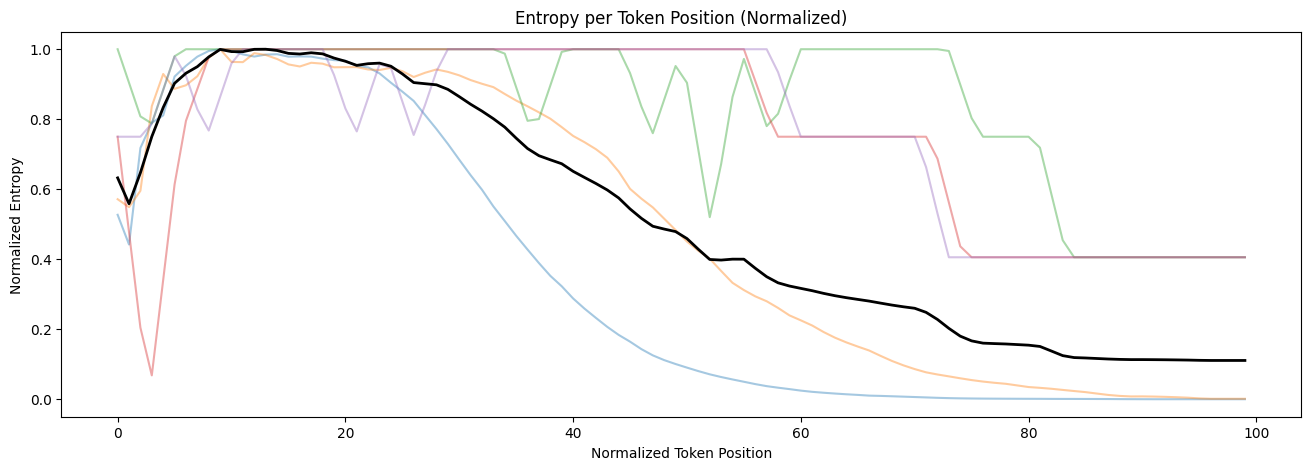


--- Cluster S -1 ---
Sample-1: Define and List Core Properties
Sample-2: List Format with Placeholder Filling
Sample-3: List of Methods with Summary Conclusion
Template: ............

--- Cluster S 519 ---
Sample-1: Define, List, and Exemplify
Sample-2: Define, List, Exemplify, Evaluate
Sample-3: Clarify, Structure, and Exemplify
Template: .........

--- Cluster S 656 ---
Sample-1: Stepwise Procedural Guide
Sample-2: Stepwise Procedural Guide
Sample-3: Stepwise Procedural Guide
Template: .........

--- Cluster S 443 ---
Sample-1: Define and Enumerate Features
Sample-2: Enumerated Feature Listing
Sample-3: Enumerated Feature Listing
Template: enumerated feature...

--- Cluster S 241 ---
Sample-1: Prompt Generation and Reframing
Sample-2: Direct Structured Prompt Generation
Sample-3: Structured Prompt Construction
Template: ............

--- Cluster S 657 ---
Sample-1: Stepwise Instructional Guide
Sample-2: Stepwise Instructional Guide
Sample-3: Stepwise Instructional Guide
Template: st

C:\Users\kachr\AppData\Local\Temp\ipykernel_23284\3109160259.py:23: RuntimeWarning: invalid value encountered in divide
  plt.plot(entropies_interp / entropies_interp.max(), label=f'Cluster {k} {cluster_id}', alpha=0.4)



--- Cluster S 246 ---
Sample-1: Comprehensive Sequential Paraphrase
Sample-2: Direct Paraphrase Generation
Sample-3: Structural Paraphrase
Template: ... paraphrase

--- Cluster S 489 ---
Sample-1: Comprehensive Sequential Explanation
Sample-2: Sequential Explanation with Worked Example
Sample-3: Sequential Explanation with General Conclusion
Template: ...... explanation...

--- Cluster S 446 ---
Sample-1: Sequential Thematic Explanation
Sample-2: Sequential Thematic Explanation
Sample-3: Sequential Thematic Elaboration
Template: sequential thematic...

--- Cluster S 269 ---
Sample-1: Historical Framing and Comparative Analysis
Sample-2: Historical Framing and Scholarly Debate
Sample-3: Historical Framing and Comparative Analysis
Template: historical framing......

--- Cluster S 213 ---
Sample-1: Structured Table with Contextual Notes
Sample-2: Table Summary with Brief Justification
Sample-3: Table with Detailed Justification
Template: table table with...

--- Cluster S 665 ---
Sample-

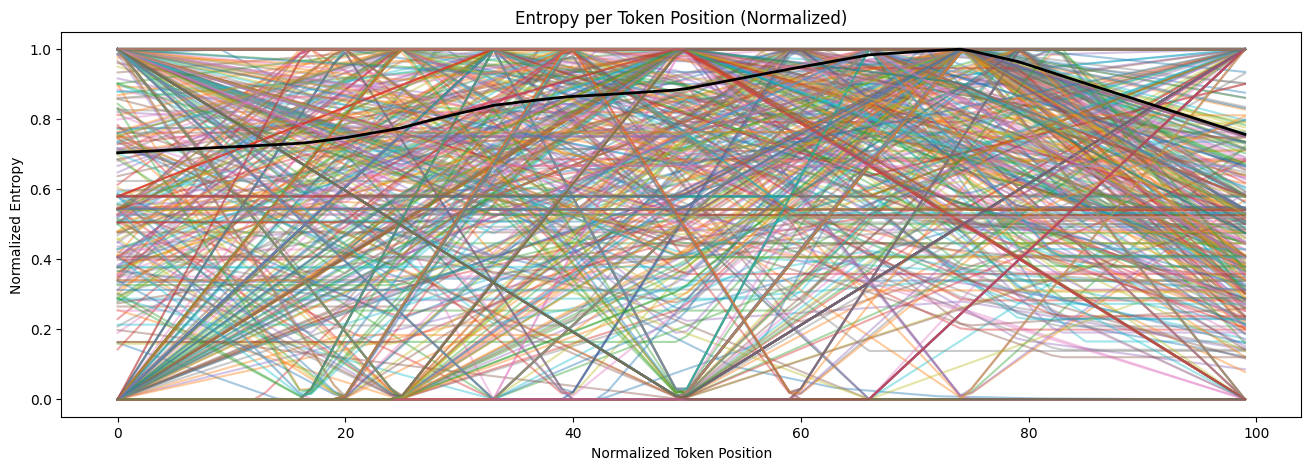

In [ ]:

cluster_dict = {} # [M/T/S][cluster_id][sample_txt]
for k, lab in labels.items():
    
    cluster_dict[k] = defaultdict(list)
    for i, label in enumerate(lab):
            cluster_dict[k][label].append(list(prompts[k])[i])

    # Print samples
    plt.figure(figsize=(16,5))
    NORM_LENGTH = 100
    mean = np.zeros(NORM_LENGTH)  # Initialize mean for entropies
    for cluster_id, samples in cluster_dict[k].items():
        template, entropies = entropy_based_template_generator(samples, 0.8)
        entropies = np.array(entropies)
        # Normalize to fixed length
        x_original = np.linspace(0, 1, len(entropies))
        x_target = np.linspace(0, 1, NORM_LENGTH)
        entropies_interp = np.interp(x_target, x_original, entropies)

        plt.plot(entropies_interp / entropies_interp.max(), label=f'Cluster {k} {cluster_id}', alpha=0.4)
        mean += entropies_interp

        print(f"\n--- Cluster {k} {cluster_id} ---")
        print(f"Sample-1: {samples[0]}")
        print(f"Sample-2: {samples[1]}")
        print(f"Sample-3: {samples[2]}")
        print(f"Template: {template}")

    mean /= len(cluster_dict[k])
    plt.plot(mean / mean.max(), label='Mean', color='black', linewidth=2)
    plt.xlabel('Normalized Token Position')
    plt.ylabel('Normalized Entropy')
    plt.title('Entropy per Token Position (Normalized)')
    plt.show()



In [27]:
cluster_dict

{'M': defaultdict(list,
             {-1: ["Begins by interpreting the user's request, providing a general definition of 'signal' and establishing the context for further explanation.",
               "Signals intent to fulfill the user's request and frames the response as a list, indicating understanding of the instruction.",
               "Begins by interpreting the user's request, defining data mining, and setting a context for the explanation.",
               "Restates the user's goal and frames the response as a set of methodologies to address the problem, indicating an intent to provide actionable solutions.",
               'Acknowledges the request and frames the response as a list of five writing prompts, directly referencing the novel and story.',
               'Affirms knowledge and frames the response by situating the framework within the broader context of storytelling archetypes and its historical use.',
               "Restates the user's request and frames the respon

In [28]:
for k in cluster_dict.keys():
    for cluster, sentences in cluster_dict[k].items():
        for sent in sentences:
            if k == 'S':
                key_a = "S_a"
                key_b = "S_b"
            else:
                key_a = f'{k}_a_text'
                key_b = f'{k}_b_text'
            mask_a = (new_df[key_a] == sent)
            mask_b = (new_df[key_b] == sent)
            new_df.loc[mask_a,f'{k}_a_cid'] = cluster
            new_df.loc[mask_b,f'{k}_b_cid'] = cluster

In [29]:
new_df

query  \
0     Define Signal Discuss its various properties w...   
1     Please make a list of independent Fertility co...   
2     Explain various data mining functionalities wi...   
3     How do I change the short cut on mac osx to to...   
4     I have a project where we deploy the "Vertex A...   
...                                                 ...   
9114  I want to open the developler tools in chrome ...   
9115  Market trends in the 13th century in france\n<...   
9116  how the HS code reffers to commodity code and ...   
9117  Historically, when interest rates flatten from...   
9118  Here are column names of a spreadsheet called ...   

                                               output_a  \
0     A signal is a form of energy that is used to t...   
1     Sure, here are some independent Fertility coac...   
2     Data mining is a process of discovering patter...   
3     To change the shortcut on Mac OS X to toggle t...   
4     To accurately calculate the roundtrip time for...   
...                                                 ...   
9114  I'm here to help! It's possible that the websi...   
9115  The economic and agricultural growth in 13th c...   
9116  The HS code, commodity code, and commodity fam...   
9117  For each of the housing market declines listed...   
9118  The column names titled 'Everyday Financials' ...   

                                               M_a_text  \
0     Begins by interpreting the user's request, pro...   
1     Signals intent to fulfill the user's request a...   
2     Begins by interpreting the user's request, def...   
3     Sets up a clear instructional intent, restatin...   
4     Restates the user's goal and frames the respon...   
...                                                 ...   
9114  Expresses intent to help and frames the proble...   
9115  Begins by framing the historical context and c...   
9116  Begins by framing the answer as a summary and ...   
9117  Restates the user's comparative causal questio...   
9118  The response frames the spreadsheet as relatin...   

                                               T_a_text  \
0     Transitions into a structured breakdown of sig...   
1     Implements the plan by presenting a numbered l...   
2     Transitions into a structured list, systematic...   
3     Implements a detailed, sequential procedure wi...   
4     Organizes the answer as a numbered list of dis...   
...                                                 ...   
9114  Suggests a step-by-step approach to confirm th...   
9115  Considers possible indirect effects, explores ...   
9116  Implements the plan by sequentially defining e...   
9117  Implements a structured, itemized approach by ...   
9118  Lists and briefly describes the types of finan...   

                                               A_a_text M_a_span   T_a_span  \
0     A signal is a form of energy that is used to t...  [0, 27]  [28, 102]   
1     1. Fertility Authority\n2. Fertility Solutions...  [0, 18]   [19, 70]   
2     These are just a few examples of the many diff...  [0, 27]  [28, 169]   
3     That's it! Now you can use the key combination...  [0, 18]  [19, 143]   
4     By using one or more of these methodologies, y...  [0, 19]  [20, 120]   
...                                                 ...      ...        ...   
9114  If you need to use the developer tools on this...  [0, 33]  [34, 107]   
9115  Overall, the 13th century was a time of signif...  [0, 34]  [35, 130]   
9116  In summary, HS codes, commodity codes, and com...  [0, 19]  [20, 117]   
9117  In all three cases, a change in the Federal Re...  [0, 27]  [28, 172]   
9118  Based on the column names, it appears that thi...  [0, 20]   [20, 74]   

        A_a_span                                             S_a  \
0       [0, 121]                 Define and List Core Properties   
1       [19, 70]            List Format with Placeholder Filling   
2     [170, 239]                     Define, List, and Exempl

In [30]:
new_df.to_json("clustered_data.jsonl")

In [2]:
new_df = pd.read_json('clustered_data.jsonl')

In [28]:
new_df.isna().sum()

query          0
output_a       0
M_a_text       0
T_a_text       0
A_a_text       0
M_a_span       0
T_a_span       0
A_a_span       0
S_a            0
output_b       0
M_b_text       0
T_b_text       0
A_b_text       0
M_b_span       0
T_b_span       0
A_b_span       0
S_b            0
label          0
len_a          0
len_b          0
start_M_a      0
end_M_a        0
start_T_a      0
end_T_a        0
start_A_a      0
end_A_a        0
start_M_b      0
end_M_b        0
start_T_b      0
end_T_b        0
start_A_b      0
end_A_b        0
M_a_cid       87
M_b_cid      368
T_a_cid      109
T_b_cid      172
S_a_cid        0
S_b_cid        0
dtype: int64

In [29]:
new_df.dropna(inplace=True)

In [30]:
A_group = new_df[['M_a_cid','T_a_cid', 'S_a_cid']]
B_group = new_df[['M_b_cid','T_b_cid', 'S_b_cid']]
AB_group = new_df[['M_a_cid','T_a_cid', 'S_a_cid', 'M_b_cid','T_b_cid', 'S_b_cid', 'label']]
AB_group = AB_group.drop_duplicates()
label = new_df['label']

In [33]:
unique_tuples = np.vstack((A_group.values, B_group.values))
unique_tuples = np.unique(unique_tuples, axis=0)

In [34]:
AB_group

M_a_cid  T_a_cid  S_a_cid  M_b_cid  T_b_cid  S_b_cid  label
0        -1.0      2.0       -1     -1.0      2.0       -1      1
1        -1.0      2.0       -1    159.0      2.0       -1      3
2        -1.0      2.0      519     -1.0      2.0      682      1
3       189.0      2.0      655     -1.0      2.0       -1      0
5        -1.0      2.0       -1     -1.0      2.0       -1      0
...       ...      ...      ...      ...      ...      ...    ...
9104     -1.0      2.0       -1     -1.0      2.0      440      0
9109     -1.0      2.0        3     -1.0      2.0       -1      0
9110     -1.0      2.0      587     -1.0      2.0      711     -1
9114     -1.0      2.0      121     -1.0      2.0      142      1
9118     29.0      2.0       -1     -1.0      2.0       -1      1

[3845 rows x 7 columns]

In [66]:
split_df = {}
for u in unique_tuples:
    split_df[str(u)] = AB_group[np.all(AB_group[["M_a_cid","T_a_cid","S_a_cid"]] == u, axis=1) | np.all(AB_group[["M_b_cid","T_b_cid","S_b_cid"]] == u, axis=1)]

In [18]:
unique_tuples[0]

array([-1., -1., -1.])

In [71]:
unique_tuples[100], split_df[str(unique_tuples[100])]

(array([ -1.,  -1., 523.]),
       M_a_cid  T_a_cid  S_a_cid  M_b_cid  T_b_cid  S_b_cid  label
 3231     26.0     -1.0       -1     -1.0     -1.0      523      2
 6409     81.0      2.0       -1     -1.0     -1.0      523     -1)

In [179]:
def tuple_key(m, t, s):
    return (int(m), int(t), int(s))

edges = []

for _, row in new_df.iterrows():
    A = tuple_key(row['M_a_cid'], row['T_a_cid'], row['S_a_cid'])
    B = tuple_key(row['M_b_cid'], row['T_b_cid'], row['S_b_cid'])
    label = row['label']
    
    if label == 0:
        continue
    elif label < 0:
        edges.append((B, A, abs(label))) # less prefered -> more prefered edge
    else:
        edges.append((A, B, abs(label))) # less prefered -> more prefered edge


In [ ]:

# Build a directed weighted graph
G = nx.DiGraph()
for a, b, strength in edges:
    G.add_edge(a, b, weight=strength)

# Now get the adjacency matrix in consistent node order
nodes = list(G.nodes)
adj = nx.to_numpy_array(G, nodelist=nodes, weight='weight')

# Optionally symmetrize (for methods like PCA)
sim_matrix = adj + adj.T  # or use a custom kernel


In [181]:
pos = nx.spring_layout(G, seed=42, k=0.6)
pagerank_scores = nx.pagerank(G, alpha=0.85, weight='weight')

In [183]:
sorted_scores = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
print("Top (M, T, S) tuples by PageRank:\n")
for node, score in sorted_scores[:10]:
    print(f"Tuple {node} → Score: {score:.4f}")

Top (M, T, S) tuples by PageRank:

Tuple (-1, 2, -1) → Score: 0.2120
Tuple (-1, -1, -1) → Score: 0.0159
Tuple (60, 2, 90) → Score: 0.0058
Tuple (-1, 2, 45) → Score: 0.0057
Tuple (-1, 2, 617) → Score: 0.0043
Tuple (80, 2, -1) → Score: 0.0043
Tuple (54, 2, -1) → Score: 0.0043
Tuple (36, 2, -1) → Score: 0.0041
Tuple (55, 2, -1) → Score: 0.0039
Tuple (-1, 2, 73) → Score: 0.0034


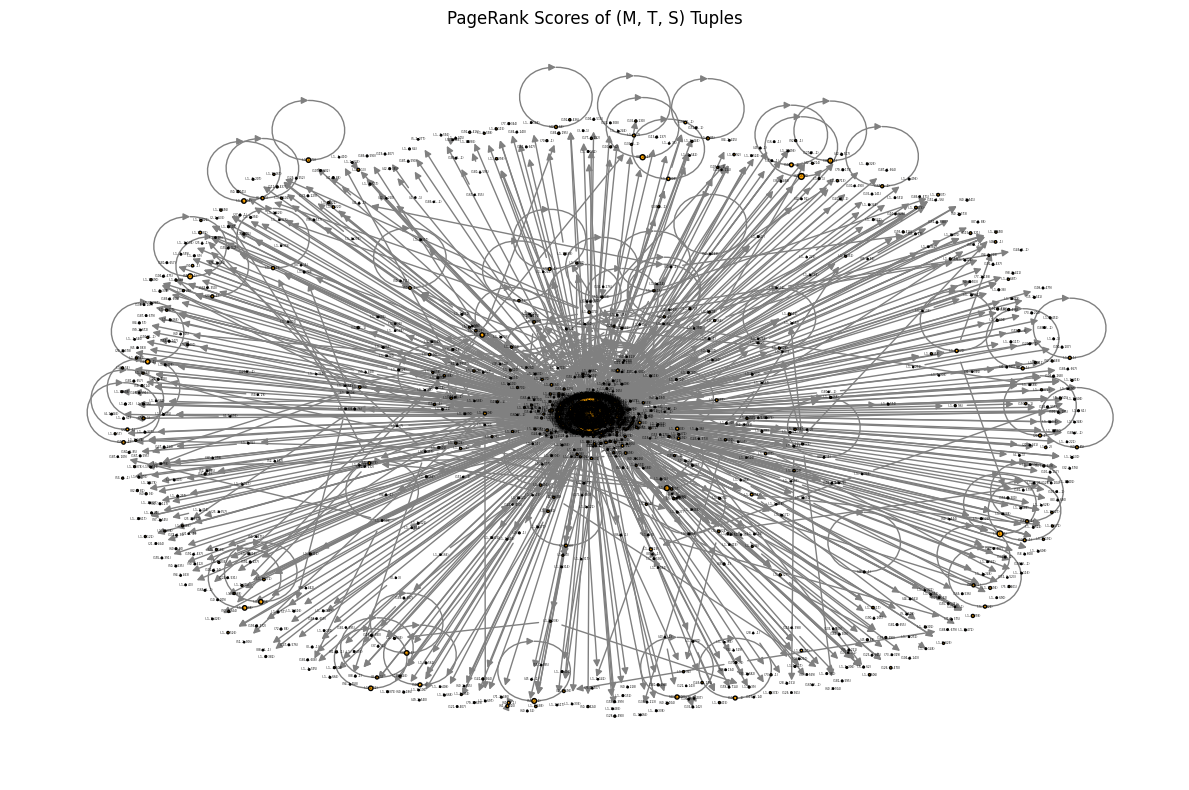

In [184]:
plt.figure(figsize=(12, 8))

# Use PageRank values to scale node sizes
node_sizes = [pagerank_scores[node] * 3000 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=42), node_size=node_sizes, node_color='orange', edgecolors='black')
nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=42), edge_color='gray', arrows=True)
nx.draw_networkx_labels(G, pos=nx.spring_layout(G, seed=42), font_size=2)

plt.title("PageRank Scores of (M, T, S) Tuples")
plt.axis('off')
plt.tight_layout()
plt.show()

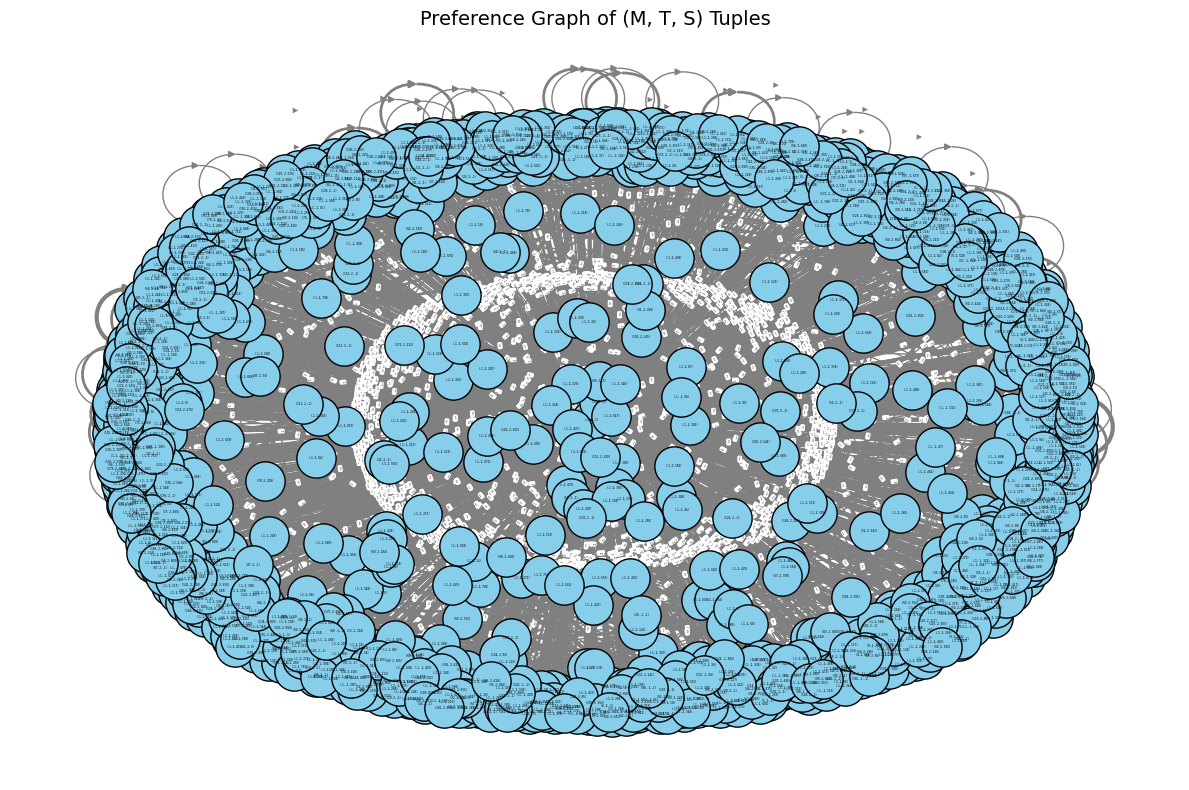

In [174]:
plt.figure(figsize=(12, 8))

nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800, edgecolors='black')

edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, width=edge_weights)

nx.draw_networkx_labels(G, pos, font_size=2)

# Draw edge labels (weights)
edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=2)

plt.title("Preference Graph of (M, T, S) Tuples", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:

embedding = umap.UMAP(n_components=2, metric='precomputed').fit_transform(1 / (sim_matrix + 1e-6))  # inverse = similarity to distance


c:\Users\kachr\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


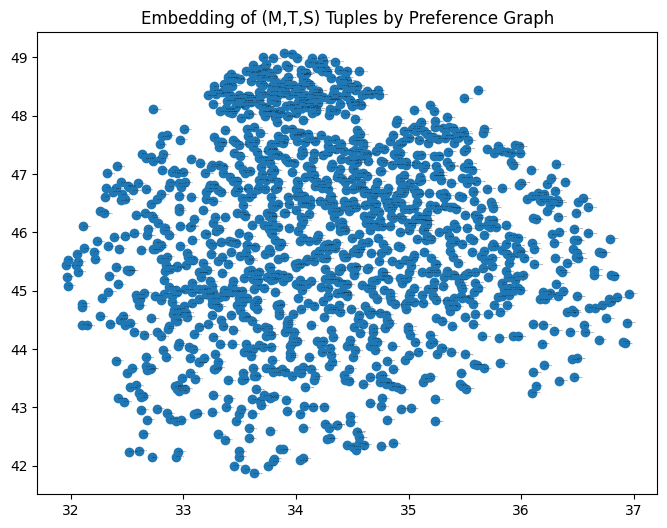

In [176]:
plt.figure(figsize=(8,6))
plt.scatter(embedding[:,0], embedding[:,1])
for i, node in enumerate(nodes):
    plt.text(embedding[i,0], embedding[i,1], str(node), fontsize=1)
plt.title("Embedding of (M,T,S) Tuples by Preference Graph")
plt.show()

In [ ]:

embedding = SpectralEmbedding(n_components=2, affinity='precomputed').fit_transform(sim_matrix)


c:\Users\kachr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


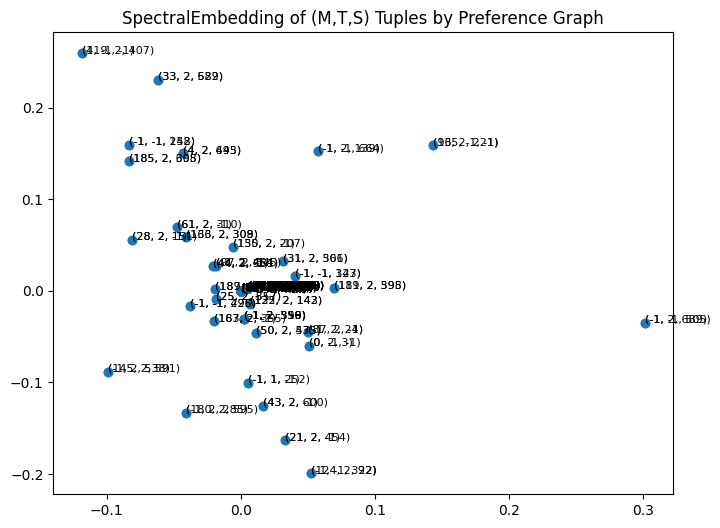

In [178]:
plt.figure(figsize=(8,6))
plt.scatter(embedding[:,0], embedding[:,1])
for i, node in enumerate(nodes):
    plt.text(embedding[i,0], embedding[i,1], str(node), fontsize=8)
plt.title("SpectralEmbedding of (M,T,S) Tuples by Preference Graph")
plt.show()